In [1]:
import pickle
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import itertools
import cv2
import ipyplot

In [2]:
VALID_SPOOF_LABELS = [
    "spoof",
    "print",
    "screen",
    "cutout",
    "half_face",
    "mask",
    "paper",
    "printed",
    "Face Mask",
    "Full Person",
    "Half Bottom",
    "Half Top",
    "Printed Glossy",
    "Printed Laserjet",
    "Printed Matte",
    "Printed Matte (Wrong Side)",
    "Printed Plain",
    "Printed Silky",
    "Screen",
    "printed_plain",
    "printed_matte",
    "printed_matte_ws",
    "printed_glossy",
    "face_mask",
    "printed_matte_(wrong_side)",
    "printed_silky",
    "full_person",
    "half_bottom",
    "half_top",
    "printed_laserjet",
]

def set_label(img_path):
    for lbl in VALID_SPOOF_LABELS:
        if lbl in img_path:
            return lbl
    
    return "None"

In [3]:
def read_pickle(pickle_file_path):
    with open(pickle_file_path, "rb") as pklfile:
        return pickle.load(pklfile)

pd.options.display.max_colwidth = None
%matplotlib widget

In [165]:
TRAIN_DATA_PATH = [
    "./embedding_data/ssdg_baseline_OCItoM_all_no_blankskip/msu_mfsd.pkl",
]

TEST_DATA_PATH = "./embedding_data/ssdg_baseline_OCItoM_all_no_blankskip/msu_mfsd.pkl"
DISTANCE_TYPE="euclidean" # choose "euclidean" or "cosine"
num_nearest = 5 # number of nearest neighbour images to be shown
test_data_idx = 0 # choose test data to be query

In [166]:
train_features = []
train_img_paths = []
training_data = []

test_features = []
test_img_paths = []
testing_data = []

for train_data_path in TRAIN_DATA_PATH:
    with open(train_data_path, "rb") as pkl:
        pkl_file = pickle.load(pkl)
        f = np.concatenate((pkl_file['main_embs'], pkl_file['border_embs']), axis=1)
        i = pkl_file.get("img_paths")
        for a, b in zip(f, i):
            train_features.append(a)
            train_img_paths.append(b)

for x, y in zip(train_features, train_img_paths):
    training_data.append({"features": x, "img_path": y})

with open(TEST_DATA_PATH, "rb") as pkl:
    pkl_file = pickle.load(pkl)
    f = np.concatenate((pkl_file['main_embs'], pkl_file['border_embs']), axis=1)
    i = pkl_file.get("img_paths")
    for a, b in zip(f, i):
        test_features.append(a)
        test_img_paths.append(b)

for x, y in zip(test_features, test_img_paths):
    testing_data.append({"features": x, "img_path": y})

# View Testing Data

In [167]:
a = pd.DataFrame(testing_data)["img_path"]

print("Test Data")
print(a)

Test Data
0         18_04_2022_iOS\raw\face_mask\Ciuiggri-iPhone11--2022-04-19-01_02_15-frame1.png
1         18_04_2022_iOS\raw\face_mask\Ciuiggri-iPhone11--2022-04-19-01_02_15-frame2.png
2         18_04_2022_iOS\raw\face_mask\Ciuiggri-iPhone11--2022-04-19-01_02_15-frame3.png
3         18_04_2022_iOS\raw\face_mask\Ciuiggri-iPhone11--2022-04-19-01_02_19-frame1.png
4         18_04_2022_iOS\raw\face_mask\Ciuiggri-iPhone11--2022-04-19-01_02_19-frame2.png
                                              ...                                       
3889    18_04_2022_iOS\raw\screen\Willy Wijaya-iPhone 7+--2022-04-18-15_29_10-frame2.png
3890    18_04_2022_iOS\raw\screen\Willy Wijaya-iPhone 7+--2022-04-18-15_29_10-frame3.png
3891    18_04_2022_iOS\raw\screen\Willy Wijaya-iPhone 7+--2022-04-18-15_29_19-frame1.png
3892    18_04_2022_iOS\raw\screen\Willy Wijaya-iPhone 7+--2022-04-18-15_29_19-frame2.png
3893    18_04_2022_iOS\raw\screen\Willy Wijaya-iPhone 7+--2022-04-18-15_29_19-frame3.png
Name: img_p

In [168]:
train_ftrs = []
for i in training_data:
    train_ftrs.append(i["features"])

test_ftrs = np.array(testing_data[test_data_idx]["features"]).reshape(1, -1)

In [169]:
if DISTANCE_TYPE == "euclidean":
    dist = euclidean_distances(test_ftrs, np.array(train_ftrs))
elif DISTANCE_TYPE == "cosine":
    dist = cosine_similarity(test_ftrs, np.array(train_ftrs))

array_dist = np.array(dist)

In [170]:
list_dist = list(itertools.chain.from_iterable(dist))

if DISTANCE_TYPE == "euclidean":
    list_dist = sorted(list_dist, reverse=False)
elif DISTANCE_TYPE == "cosine":
    list_dist = sorted(list_dist, reverse=True)

list_dist = np.array(list_dist).reshape(-1)

18_04_2022_iOS\raw\face_mask\Ciuiggri-iPhone11--2022-04-19-01_02_15-frame1.png
18_04_2022_iOS\raw\face_mask\Ciuiggri-iPhone11--2022-04-19-01_02_15-frame1.png
18_04_2022_iOS\raw\face_mask\Ciuiggri-iPhone11--2022-04-19-01_02_15-frame3.png
18_04_2022_iOS\raw\face_mask\Ciuiggri-iPhone11--2022-04-19-01_02_15-frame2.png
18_04_2022_iOS\raw\face_mask\Ciuiggri-iPhone11--2022-04-19-01_02_19-frame3.png



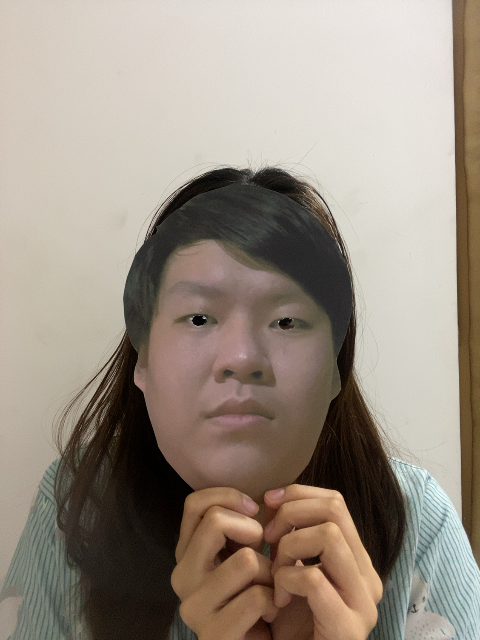
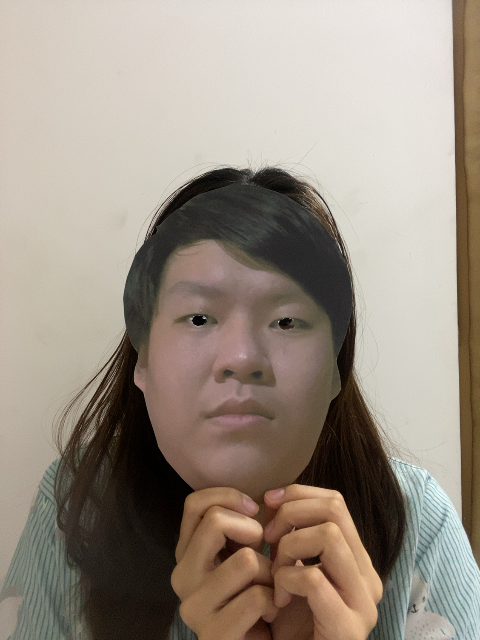
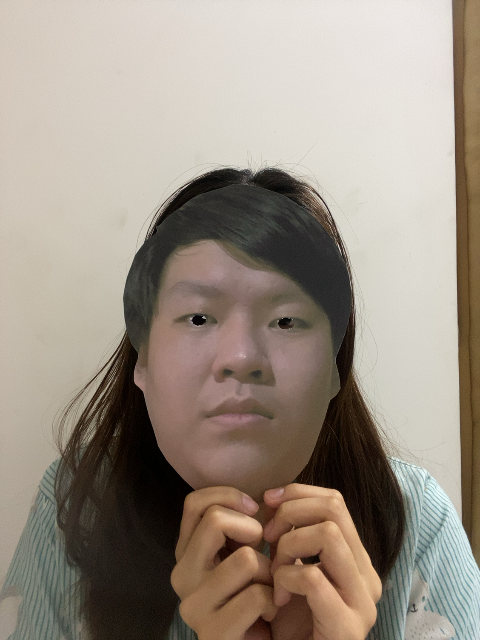
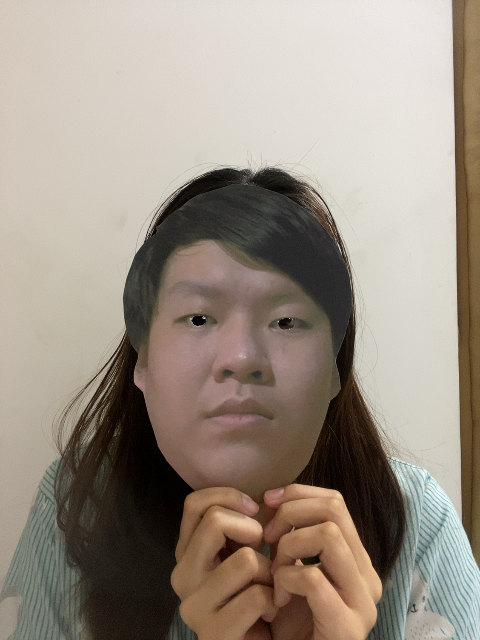
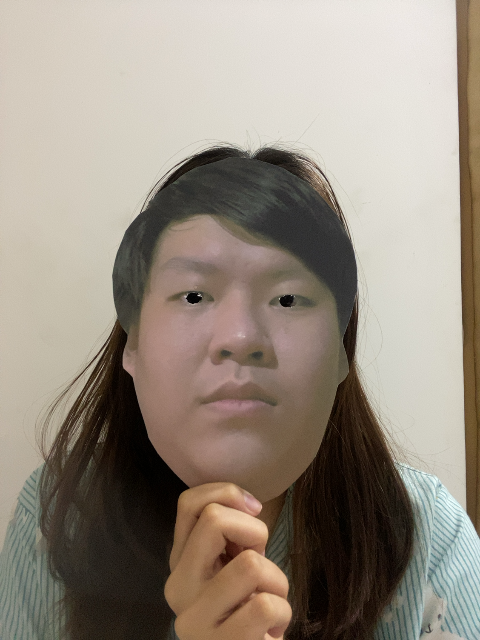
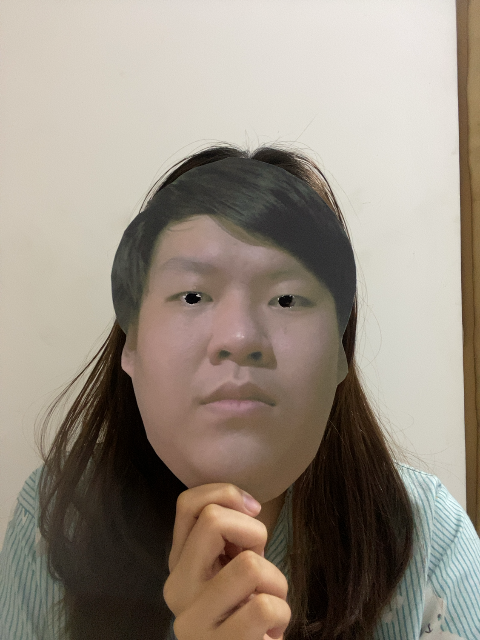


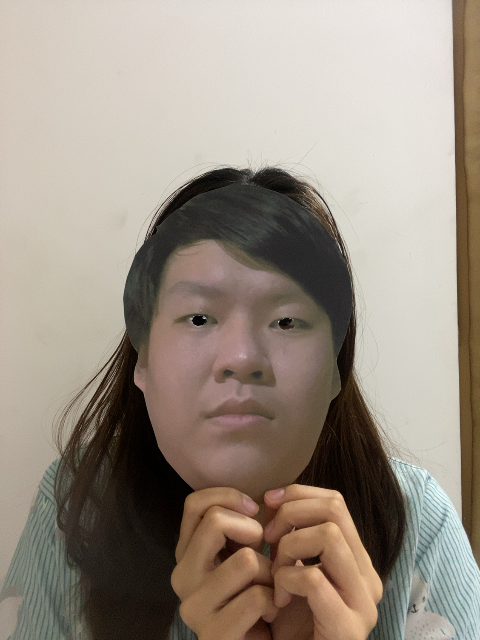
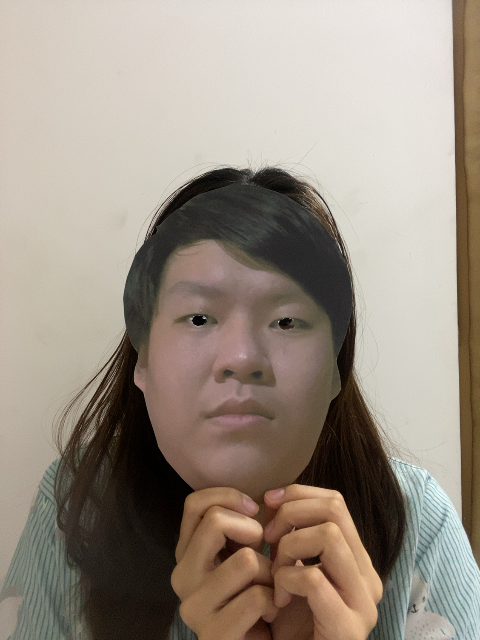
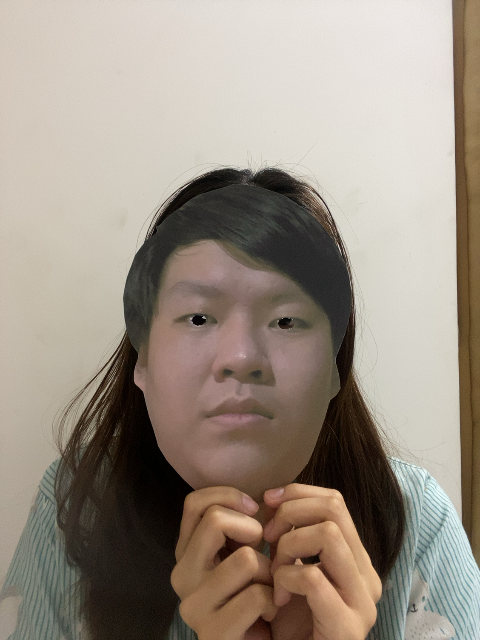
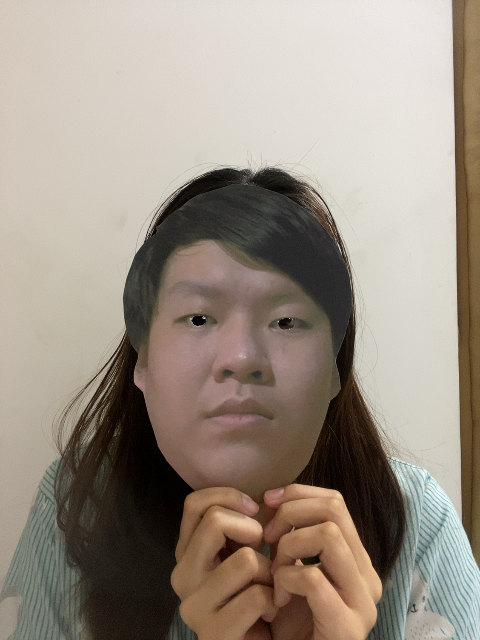
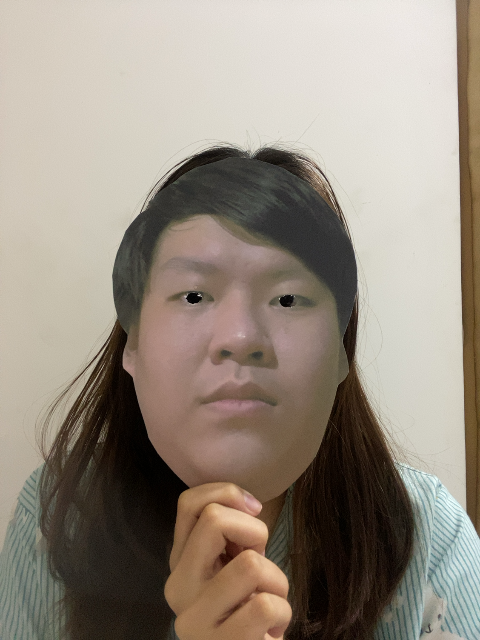
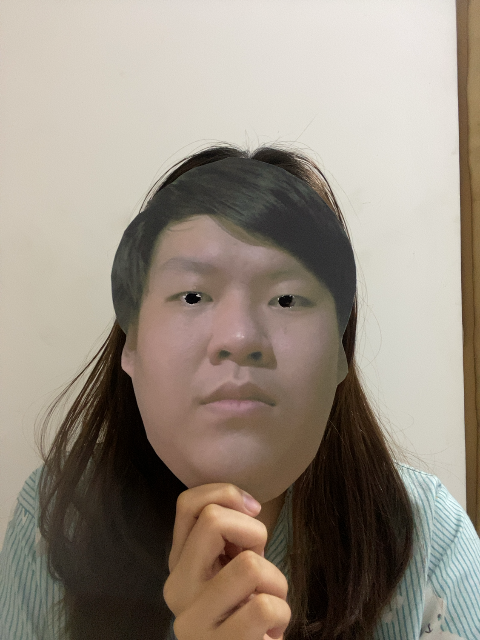

In [171]:
img_list = []
lbl_list = []

img_path = str(testing_data[test_data_idx]["img_path"])
lbl = set_label(img_path)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_list.append(img)
lbl_list.append(lbl + " (Query)")

for i in range(num_nearest):
    print(img_path)
    img_path = str(training_data[np.where(array_dist == list_dist[i])[1][0]]["img_path"])
    lbl = set_label(img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_list.append(img)
    lbl_list.append(lbl)

ipyplot.plot_images(img_list, lbl_list)